In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [7]:
train_path = os.path.join('..','data','train.csv')
test_path = os.path.join('..','data','test.csv')
# monthly_card_path = os.path.join('..','data','monthly_card_features.csv')

In [10]:
train_df = pd.read_csv(train_path, parse_dates=["first_active_month"])
test_df = pd.read_csv(test_path, parse_dates=["first_active_month"])
# monthly_card_df = pd.read_csv(monthly_card_path)

In [12]:
monthly_card_df.head()

,card_id,month_lag,amt_total,amt_new,NDR,n_new_merchants,n_total_merchants
0,C_ID_00007093c1,-12,1100.20,1100.2,1.000000,3.0,3.0
1,C_ID_00007093c1,-11,1168.90,0.0,0.000000,NaN,3.0
2,C_ID_00007093c1,-10,1633.25,742.8,0.454799,3.0,6.0
3,C_ID_00007093c1,-9,2691.13,2420.0,0.899251,3.0,9.0
4,C_ID_00007093c1,-8,2876.63,1925.0,0.669186,5.0,14.0


In [13]:
train_df = train_df.join(monthly_card_df.groupby('card_id').agg({
    'amt_total': [np.min, np.mean, np.max],
    'NDR':       [np.min, np.mean, np.max],
    'n_new_merchants':   np.mean,
    'n_total_merchants': np.max
}))
test_df = test_df.join(monthly_card_df.groupby('card_id').agg({
    'amt_total': [np.min, np.mean, np.max],
    'NDR':       [np.min, np.mean, np.max],
    'n_new_merchants':   np.mean,
    'n_total_merchants': np.max
}))

/Users/henrypark/anaconda/envs/tfdeeplearning/lib/python3.5/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


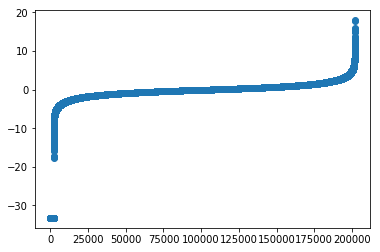

In [5]:
plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))

In [10]:
hist_trans_path= os.path.join('..','data','historical_transactions.csv')
hist_trans_df = pd.read_csv(hist_trans_path)

In [11]:
hist_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [12]:
hist_temp = hist_trans_df.groupby("card_id")
hist_temp = hist_temp["purchase_amount"].size().reset_index()
hist_temp.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, hist_temp, on="card_id", how="left")
test_df = pd.merge(test_df, hist_temp, on="card_id", how="left")

In [13]:
hist_temp = hist_trans_df.groupby("card_id") 
hist_temp = hist_temp["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
hist_temp.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train_df, hist_temp, on="card_id", how="left")
test_df = pd.merge(test_df, hist_temp, on="card_id", how="left")

In [13]:
# bins = np.percentile(train_df["mean_hist_trans"], range(0,101,10))
# train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
# #cnt_srs = train_df.groupby("binned_mean_hist_trans")[target_col].mean()

# plt.figure(figsize=(12,8))
# sns.boxplot(x="binned_mean_hist_trans", y="target", data=train_df, showfliers=False)
# plt.xticks(rotation='vertical')
# plt.xlabel('Binned Mean Historical Transactions', fontsize=12)
# plt.ylabel('Loyalty score', fontsize=12)
# plt.title("Mean of historical transaction value (Binned) distribution")
# plt.show()

In [14]:
new_trans_path = os.path.join('..','data','new_merchant_transactions.csv')
new_trans_df = pd.read_csv(new_trans_path)

In [15]:
hist_temp = new_trans_df.groupby("card_id")
hist_temp = hist_temp["purchase_amount"].size().reset_index()
hist_temp.columns = ["card_id", "num_merch_transactions"]
train_df = pd.merge(train_df, hist_temp, on="card_id", how="left")
test_df = pd.merge(test_df, hist_temp, on="card_id", how="left")

In [16]:
hist_temp = new_trans_df.groupby("card_id")
hist_temp = hist_temp["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
hist_temp.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, hist_temp, on="card_id", how="left")
test_df = pd.merge(test_df, hist_temp, on="card_id", how="left")

In [17]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

In [18]:
model_cols = ["feature_1", "feature_2", "feature_3", "year", "month", 
               "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", 
               "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans",
              ]

In [20]:
X_train = train_df[model_cols]
y_train = train_df['target']
x_test = test_df[model_cols]
X_train = X_train.fillna(0)
x_test = x_test.fillna(0)

In [21]:
scaler = MinMaxScaler()
scaler.fit(X_train)

/Users/henrypark/anaconda/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns,index=X_train.index)
x_test = pd.DataFrame(data=scaler.transform(x_test),columns = x_test.columns,index=x_test.index)
X_train = X_train.fillna(0)

Initialize the feature variables

In [145]:
tf_columns = []
for col in model_cols:
    tf_columns.append(tf.feature_column.numeric_column(col))

In [5]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train ,batch_size=100,num_epochs=1000,
                                            shuffle=True)

NameError: name 'tf' is not defined

In [4]:
model = tf.estimator.DNNRegressor(hidden_units=[100,10,10],feature_columns=tf_columns,
                                  optimizer=

NameError: name 'tf' is not defined

In [148]:
model.train(input_fn=input_func,steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/_y/f4nlgpcs6x79pmncgymhg4hh0000gn/T/tmprkno2ew8/model.ckpt.
INFO:tensorflow:loss = 1322.1401, step = 1
INFO:tensorflow:global_step/sec: 205.799
INFO:tensorflow:loss = 232.54059, step = 101 (0.487 sec)
INFO:tensorflow:global_step/sec: 220.123
INFO:tensorflow:loss = 1616.8184, step = 201 (0.457 sec)
INFO:tensorflow:global_step/sec: 224.255
INFO:tensorflow:loss = 1484.4122, step = 301 (0.444 sec)
INFO:tensorflow:global_step/sec: 205.356
INFO:tensorflow:loss = 1346.961, step = 401 (0.487 sec)
INFO:tensorflow:global_step/sec: 244.334
INFO:tensorflow:loss = 2541.4238, step = 501 (0.409 sec)
INFO:tensorflow:global_step/sec: 231.105
INFO:tensorflow:loss = 1402.1194, step = 601 (0.434 sec)
INFO:tensorflo

INFO:tensorflow:loss = 1390.378, step = 8001 (0.396 sec)
INFO:tensorflow:global_step/sec: 236.639
INFO:tensorflow:loss = 1357.333, step = 8101 (0.423 sec)
INFO:tensorflow:global_step/sec: 251.953
INFO:tensorflow:loss = 260.07535, step = 8201 (0.399 sec)
INFO:tensorflow:global_step/sec: 246.781
INFO:tensorflow:loss = 1206.9414, step = 8301 (0.405 sec)
INFO:tensorflow:global_step/sec: 258.739
INFO:tensorflow:loss = 280.35165, step = 8401 (0.386 sec)
INFO:tensorflow:global_step/sec: 253.3
INFO:tensorflow:loss = 194.58687, step = 8501 (0.393 sec)
INFO:tensorflow:global_step/sec: 258.181
INFO:tensorflow:loss = 1463.0695, step = 8601 (0.389 sec)
INFO:tensorflow:global_step/sec: 253.277
INFO:tensorflow:loss = 2360.5508, step = 8701 (0.396 sec)
INFO:tensorflow:global_step/sec: 248.465
INFO:tensorflow:loss = 350.33325, step = 8801 (0.400 sec)
INFO:tensorflow:global_step/sec: 247.612
INFO:tensorflow:loss = 1375.4652, step = 8901 (0.407 sec)
INFO:tensorflow:global_step/sec: 197.676
INFO:tensorflo

In [149]:
predict_input_func = tf.estimator.inputs.pandas_input_fn(
      x=x_test,
      batch_size=50,
      num_epochs=1,
      shuffle=False)

In [150]:
pred_gen = model.predict(predict_input_func)

In [151]:
predictions = list(pred_gen)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/_y/f4nlgpcs6x79pmncgymhg4hh0000gn/T/tmprkno2ew8/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [152]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['predictions'])

In [153]:
np.shape(final_preds)

(123623, 1)

In [154]:
min(final_preds)

array([-7.053858], dtype=float32)

In [155]:
max(final_preds)

array([0.80892026], dtype=float32)

In [15]:
lm = LinearRegression()

In [16]:
train_x = train_df[model_cols]
train_x = train_x.fillna(0)
train_y = train_df['target'].values

In [17]:
lm.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
test_x = test_df[model_cols]
test_x = test_x.fillna(0)

In [23]:
test_pred = lm.predict(test_x)

In [24]:
submission = pd.DataFrame(test_pred)
submission.columns=['target']
submission = pd.concat([test_df['card_id'], submission], axis=1)
submission.to_csv('submission.csv', index=False)

In [25]:
np.shape(submission)

(123623, 2)

In [104]:
X_train.head()

,feature_1,feature_2,feature_3,num_hist_transactions,sum_hist_trans,mean_hist_trans,min_hist_trans,max_hist_trans,num_merch_transactions,sum_merch_trans,mean_merch_trans,min_merch_trans,max_merch_trans
0,1.00,0.5,1.0,0.088660,0.000320,2.136813e-07,0.000256,4.997350e-07,0.203704,0.320008,0.003807,0.000501,0.005822
1,0.75,0.0,0.0,0.119588,0.000312,2.901925e-07,0.000154,8.943550e-07,0.046296,0.369416,0.000466,0.000167,0.000582
2,0.25,0.5,0.0,0.014089,0.000342,1.338821e-07,0.000572,9.973500e-08,0.000000,0.389735,0.001036,0.001036,0.000601
3,0.75,1.0,0.0,0.025773,0.000339,2.048895e-07,0.000205,3.645075e-07,0.055556,0.367756,0.001825,0.000284,0.002327
4,0.00,1.0,0.0,0.045017,0.000339,7.572579e-07,0.000026,1.320725e-06,0.324074,0.282865,0.004304,0.000167,0.015469


## Logistic Regression with Oversampling

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
y_train = y_train > -7

In [26]:
y_train.head(10)

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
Name: target, dtype: bool

In [27]:
clf = LogisticRegression(random_state=0, solver='liblinear',multi_class='ovr').fit(X_train, y_train)

In [28]:
clf.score(X_train, y_train)

0.9871778998301283

In [29]:
sum(y_train)

199329